In [1]:
#importing libraries

import numpy as np
import pandas as pd
import nltk
import re
import json
import seaborn as sns
import mysql.connector as sqlcon
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import seaborn as sns


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [2]:
#connecting to mysql local server

conn=sqlcon.connect(
    host='localhost',user='danish',
    password='Danish@2020',db='testdb', 
    auth_plugin='mysql_native_password')

cur=conn.cursor(buffered=True)


In [ ]:
#Dumping Data into ymsql database

data_file=input("enter exact file location: ")
json_data=open(data_file).read()
json_obj=json.loads(json_data)
i=0
for item in json_obj['data']:
    txt=item.get("text")
    i_d=item.get('id')
    lang=item.get('lang')
    cur.execute("SET NAMES utf8mb4")
    if lang=='en':
        cur.execute("INSERT INTO testdb.Data(id,tweet) VALUES(%s,%s)",(i_d,txt))
        i+=1
print("success with ",i)
conn.commit()


In [3]:
#Fetching Data from mySQL table

query="SELECT DISTINCT tweet FROM Data"
cur.execute(query)
data = pd.read_sql(query,conn)
data = pd.DataFrame(data['tweet'],columns=['tweet'])
data

,tweet
0,RT @theILDN: Welcome to SICAP Stories. Over th...
1,RT @PCMohanMP: Thankful to Rajasthan Cosmo Fou...
2,RT @KhushnumaKashm1: With an aim to spread awa...
3,RT @UN: Parents &amp; caregivers have faced un...
4,RT @NEWS9TWEETS: #NHRC issues advisories on th...
...,...
5588,RT @BernieSpofforth: If this is true then why ...
5589,The danger to our country right now is Joe Bid...
5590,RT @FLATHORIZON1: In Australia we have a .006%...
5591,RT @CDCgov: #DYK? You can use COVID Data Track...


In [4]:
#Data Preprocessing

def rem_extras(text):
    text=text.lower()
    text=re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([0-9])|covid|rt"," ",text)
    return text

data['cleaned'] = data['tweet'].apply(lambda x: rem_extras(x))

stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')
def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]
                                                              

data['stemmed'] = data['cleaned'].apply(lambda x: tokenize(x))
                                                              
                                                              
stopword = nltk.corpus.stopwords.words('english')

def remove(text):
    text = [word for word in text if word not in stopword]
    text = [word for word in text if (len(word)>3)]
    #
    return text
    
data['nonstop'] = data['stemmed'].apply(lambda x: remove(x))


def join(text):
    text= " ".join(word for word in text)
    return text

data['joined'] = data['nonstop'].apply(lambda x: join(x))

data

,tweet,cleaned,stemmed,nonstop,joined
0,RT @theILDN: Welcome to SICAP Stories. Over th...,welcome to sicap stories over the next ...,"[welcom, to, sicap, stori, over, the, next, da...","[welcom, sicap, stori, next, shine, light, gov...",welcom sicap stori next shine light govern pri...
1,RT @PCMohanMP: Thankful to Rajasthan Cosmo Fou...,thankful to rajasthan cosmo foundation tr...,"[thank, to, rajasthan, cosmo, foundat, trust, ...","[thank, rajasthan, cosmo, foundat, trust, dona...",thank rajasthan cosmo foundat trust donat step...
2,RT @KhushnumaKashm1: With an aim to spread awa...,with an aim to spread awareness amongst t...,"[with, an, aim, to, spread, awar, amongst, the...","[spread, awar, amongst, local, populac, regard...",spread awar amongst local populac regard effec...
3,RT @UN: Parents &amp; caregivers have faced un...,parents amp caregivers have faced uniqu...,"[parent, amp, caregiv, have, face, uniqu, amp,...","[parent, caregiv, face, uniqu, formid, challen...",parent caregiv face uniqu formid challeng dure...
4,RT @NEWS9TWEETS: #NHRC issues advisories on th...,issues advisories on the issues of ment...,"[issu, advisori, on, the, issu, of, mental, he...","[issu, advisori, issu, mental, health, bond, l...",issu advisori issu mental health bond labour m...
...,...,...,...,...,...
5588,RT @BernieSpofforth: If this is true then why ...,if this is true then why is israel who a...,"[if, this, is, true, then, whi, is, israel, wh...","[true, israel, offer, booster, still, restrict...",true israel offer booster still restrict inclu...
5589,The danger to our country right now is Joe Bid...,the danger to our country right now is joe bid...,"[the, danger, to, our, countri, right, now, is...","[danger, countri, right, biden, useless, admin...",danger countri right biden useless administr k...
5590,RT @FLATHORIZON1: In Australia we have a .006%...,in australia we have a chance of pa...,"[in, australia, we, have, a, chanc, of, pass, ...","[australia, chanc, pass, away, bigger, threat,...",australia chanc pass away bigger threat lightn
5591,RT @CDCgov: #DYK? You can use COVID Data Track...,you can use data tracker to find out...,"[you, can, use, data, tracker, to, find, out, ...","[data, tracker, find, affect, communiti, data,...",data tracker find affect communiti data tracke...


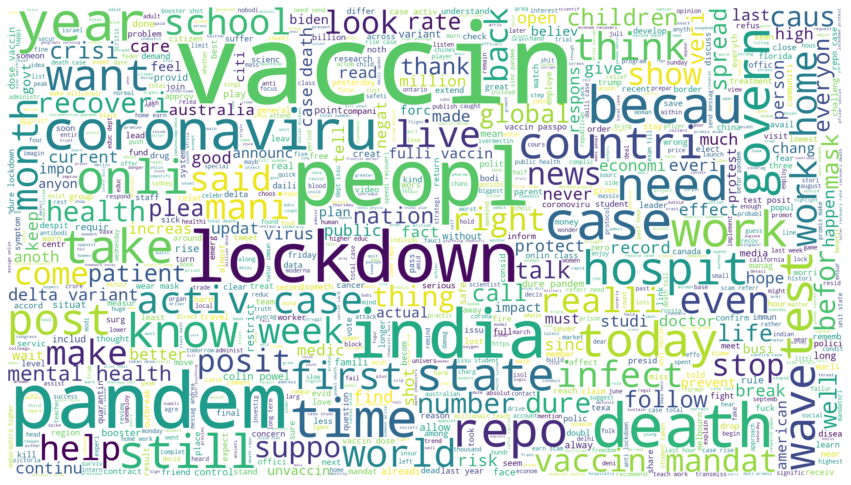

In [118]:
#Generating WordCloud
 
text = " ".join(words for words in data.joined)
wc = WordCloud(
               background_color="white",
               max_words=1000, max_font_size=256,
               random_state=42, width=1920,
               height=1080)
wc.generate(text)
plt.figure(figsize=[15,15])
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.savefig('output/Wordcloud.jpg')
plt.show()

In [71]:
import itertools
import collections
words_in_tweet = data['nonstop']

all_words = list(itertools.chain(*words_in_tweet))

# Create counter
counts = collections.Counter(all_words)

counts.most_common(15)


[('vaccin', 1462),
 ('case', 712),
 ('pandem', 632),
 ('peopl', 511),
 ('death', 462),
 ('lockdown', 410),
 ('india', 333),
 ('work', 319),
 ('like', 277),
 ('year', 247),
 ('repo', 237),
 ('coronavirus', 230),
 ('health', 227),
 ('home', 213),
 ('time', 208)]

In [72]:
def plot1(x,y):
    fig, ax = plt.subplots(figsize =(7, 9))

    # Horizontal Bar Plot
    ax.barh(y,x)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    ax.invert_yaxis()
    plt.savefig('output/wordfreq.jpg')
    plt.show()

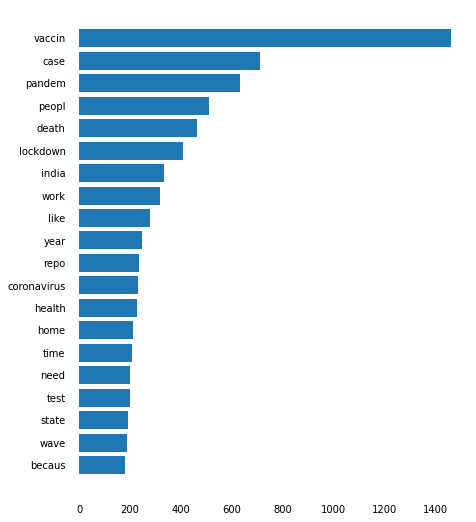

In [73]:
cf = pd.DataFrame.from_records(counts.most_common(), columns=['word','count'])
x=cf['count'].head(20)
y=cf['word'].head(20)
plot1(x,y)

In [5]:
#Text to vector transformation
desc=data['joined'].values
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(desc)


In [6]:
#dimensionality reduction

tf_idf_norm = normalize(X)
tf_idf_array = tf_idf_norm.toarray()

pca = PCA(n_components=2)
df = pca.fit_transform(tf_idf_array)

# K Means Clustering

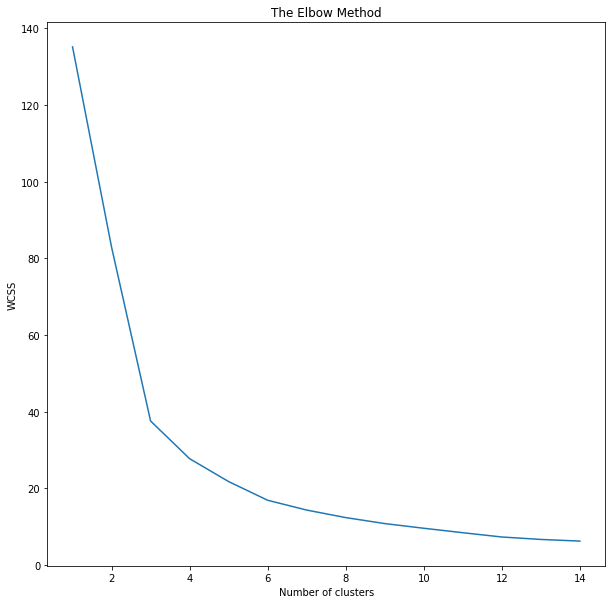

In [119]:
wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)
plt.subplots(figsize=(10,10))
plt.plot(range(1,15),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('output/elbow.jpg')
plt.show()

In [120]:
words = vectorizer.get_feature_names()
kmeans = KMeans(n_clusters = 6, n_init = 20) 
kmeans.fit(X)
# We look at top 15 features of 6 clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-15:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : work, home, need, send, messag, make, earn, referr, andrea, millionair, scam, teach, promis, everyon
1 : pandem, peopl, wave, like, india, health, post, year, time, dure, test, becaus, world, posit
2 : case, activ, death, repo, total, daili, rise, record, number, last, hour, today, recoveri, yesterday
3 : lockdown, dure, protest, anti, like, melbourn, state, time, month, sinc, first, last, year, becaus
4 : vaccin, mandat, dose, peopl, india, effect, passpo, fulli, pfizer, govern, take, administ, state, moderna
5 : death, coronavirus, powel, colin, vaccin, peopl, year, complic, state, pandem, updat, repo, fulli, mani


In [121]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs


def plot(df,k_no):
    
    x = df[k_no].features
    y = df[k_no].score
    fig, ax = plt.subplots(figsize =(7, 9))

    # Horizontal Bar Plot
    ax.barh(x,y)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    ax.invert_yaxis()
    plt.title("Cluster No %d" %(k_no+1))
    plt.savefig('output/WordsInCluster%d.jpg'%(k_no+1))
    plt.show()

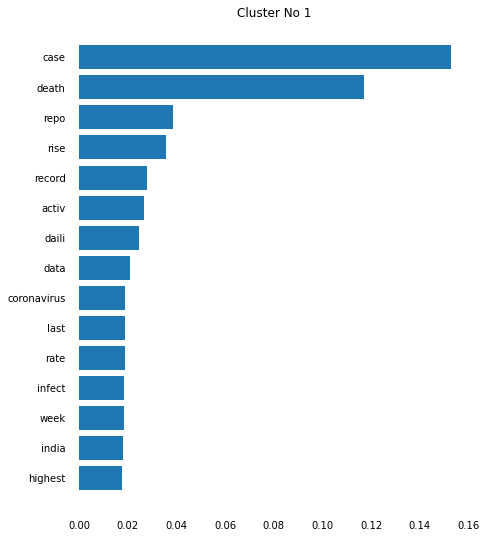

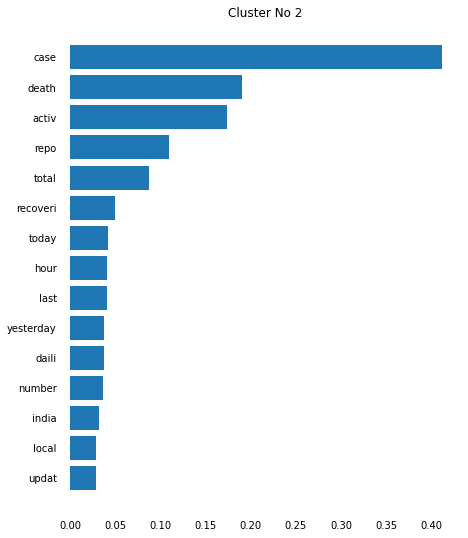

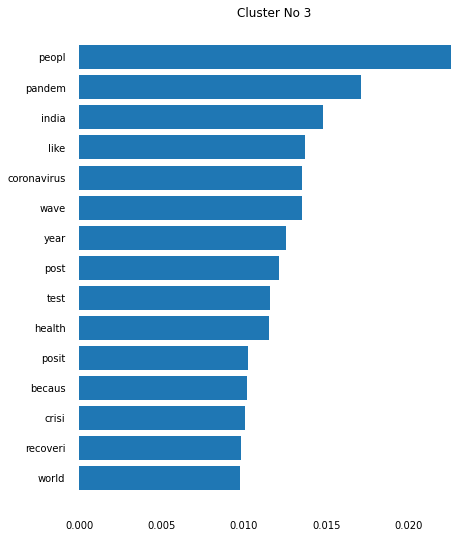

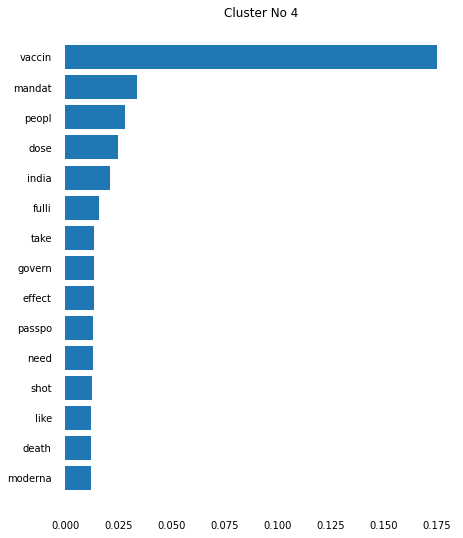

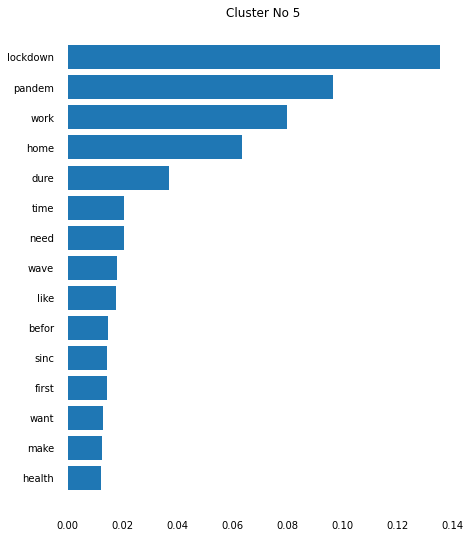

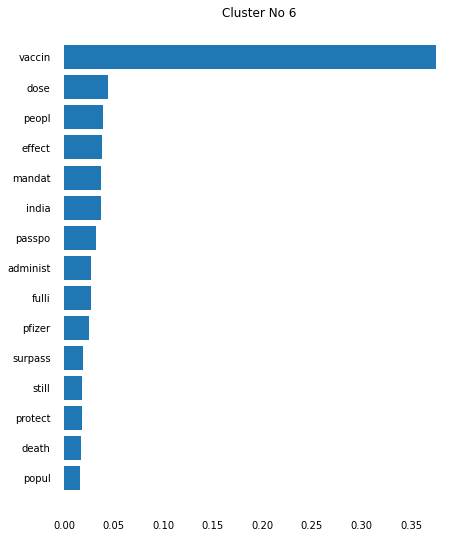

In [122]:
kmeans = KMeans(n_clusters=6, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(df)
prediction = kmeans.fit_predict(df)

dfs = get_top_features_cluster(tf_idf_array, prediction, 15)
plot(dfs,0)
plot(dfs,1)
plot(dfs,2)
plot(dfs,3)
plot(dfs,4)
plot(dfs,5)

In [80]:
def KMClusters(dframe,n_clus, iters):

    #1 Initialize the class object
    kmeans = KMeans(n_clusters= n_clus, n_init=iters)

    #2 predict the labels of clusters.
    label = kmeans.fit_predict(dframe)

    #3 Getting the Centroids
    centroids = kmeans.cluster_centers_
    u_labels = np.unique(label)

    #plotting the results:
    plt.subplots(figsize=(10,10))
    for i in u_labels:
        plt.scatter(dframe[label == i , 0] , dframe[label == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.title(str(n_clus) + ' clusters')
    plt.savefig('output/' + str(n_clus) +'clusters.jpg', format="JPG")
    plt.legend()
    plt.show()

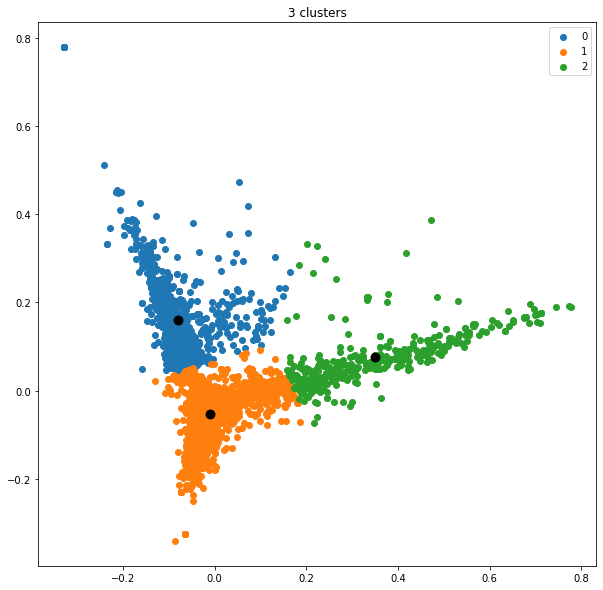

In [81]:

KMClusters(df,3,20)


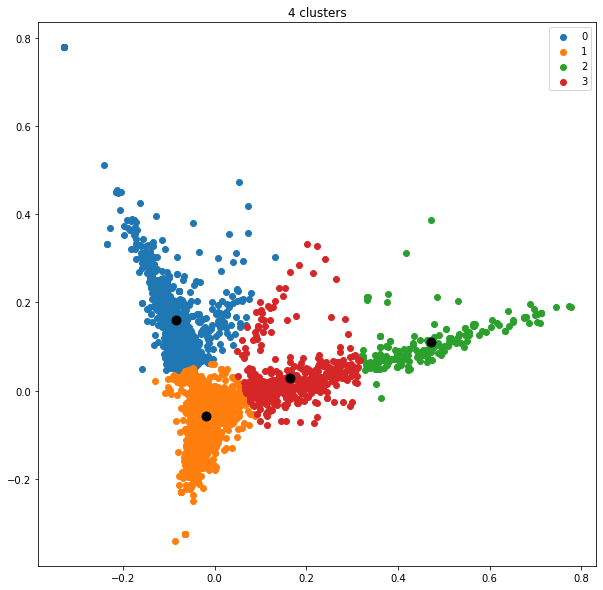

In [82]:
KMClusters(df,4,20)

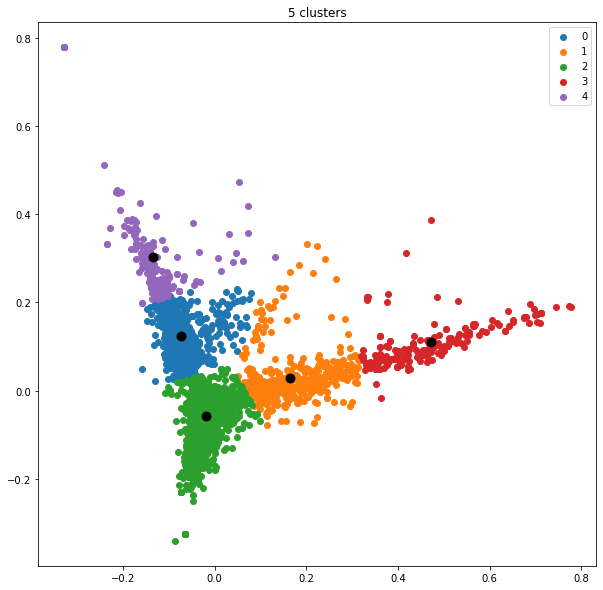

In [83]:
KMClusters(df,5,20)

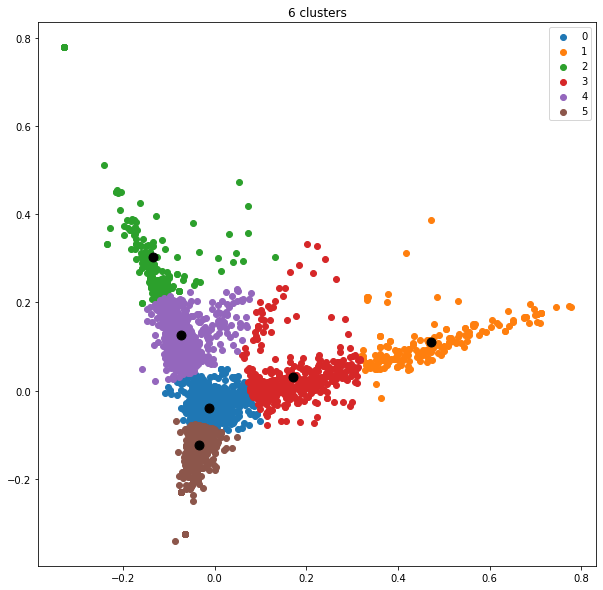

In [84]:
KMClusters(df,6,20)

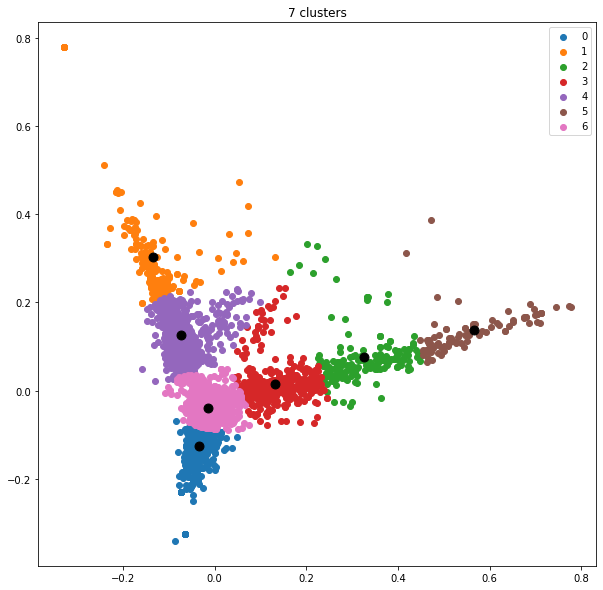

In [85]:
KMClusters(df,7,20)

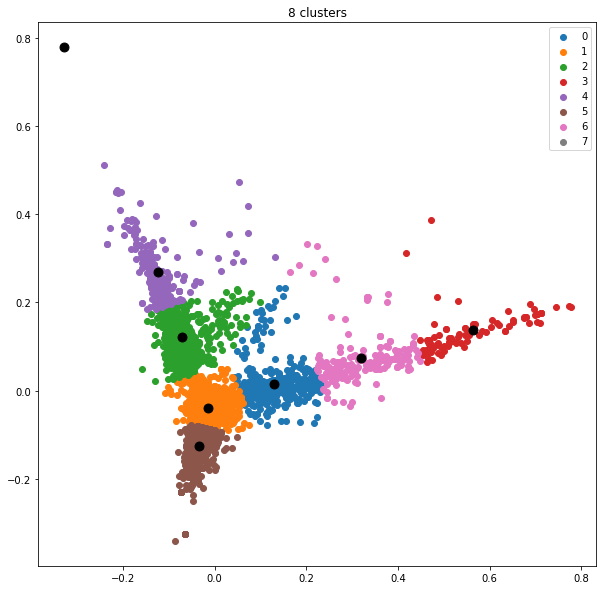

In [86]:
KMClusters(df,8,20)

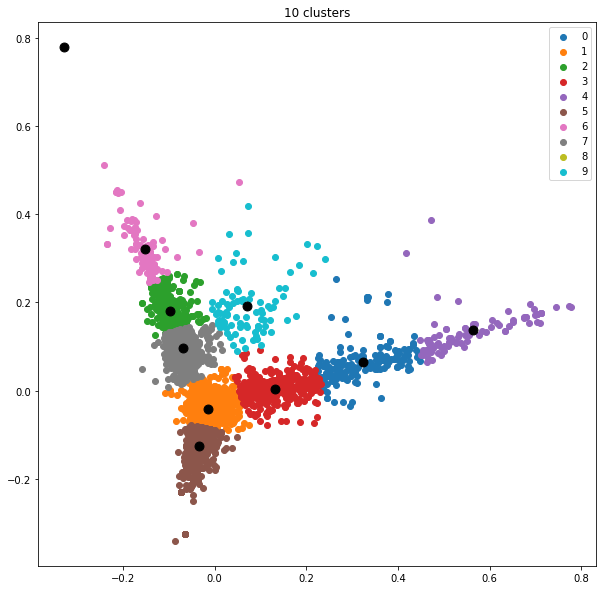

In [87]:
KMClusters(df,10,20)

# Density based clustering

In [109]:

clust = OPTICS(min_samples=50, xi=0.022, min_cluster_size=.05)

# Run the fit
clust.fit(df)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.02)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.01)

space = np.arange(len(df))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]


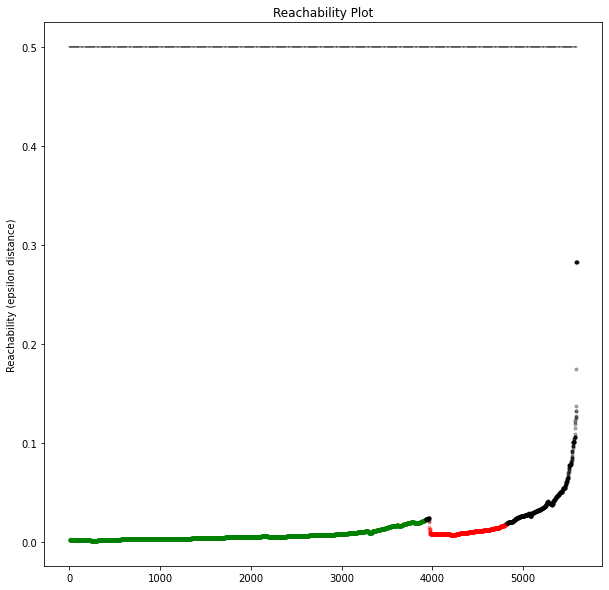

In [103]:
# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
plt.subplots(figsize=(10,10))
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    plt.plot(Xk, Rk, color, alpha=0.3)
plt.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
plt.plot(space, np.full_like(space, 0.5, dtype=float), 'k-', alpha=0.5)
plt.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
plt.ylabel('Reachability (epsilon distance)')
plt.title('Reachability Plot')
plt.savefig('output/Reachability2.jpg')
plt.show()

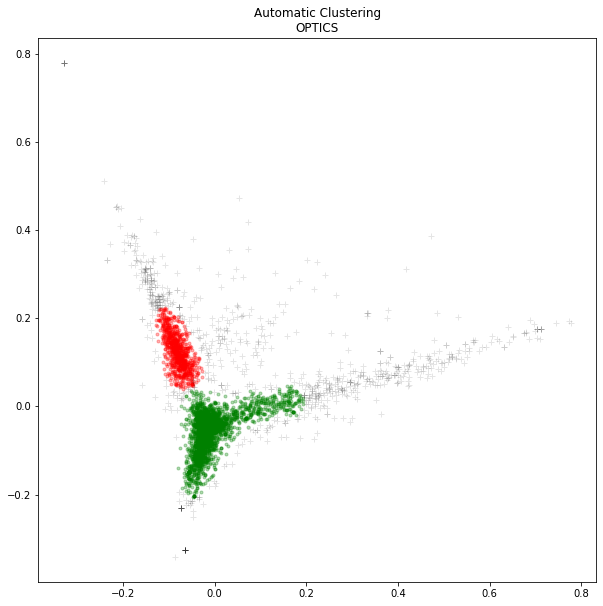

In [104]:
# OPTICS PLOT
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
plt.subplots(figsize=(10,10))
for klass, color in zip(range(0, 5), colors):
    Xk = df[clust.labels_ == klass]
    plt.plot(Xk[:, 0], Xk[:, 1], color,alpha=0.3)
plt.plot(df[clust.labels_ == -1, 0], df[clust.labels_ == -1, 1], 'k+', alpha=0.1)
plt.title('Automatic Clustering\nOPTICS')
plt.savefig('output/OPTICS.jpg')
plt.show()

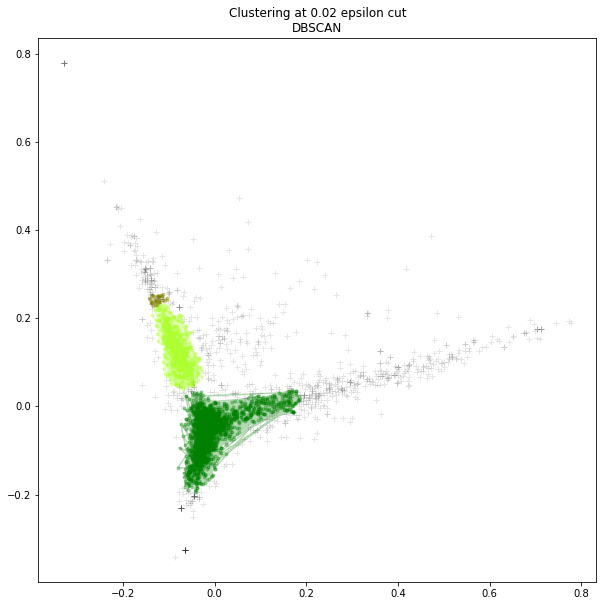

In [105]:
# DBSCAN at 0.5
colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
plt.subplots(figsize=(10,10))
for klass, color in zip(range(0, 6), colors):
    Xk = df[labels_050 == klass]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
plt.plot(df[labels_050 == -1, 0], df[labels_050 == -1, 1], 'k+', alpha=0.1)
plt.title('Clustering at 0.02 epsilon cut\nDBSCAN')
plt.savefig('output/DBSCAN@0.5.jpg')
plt.show()

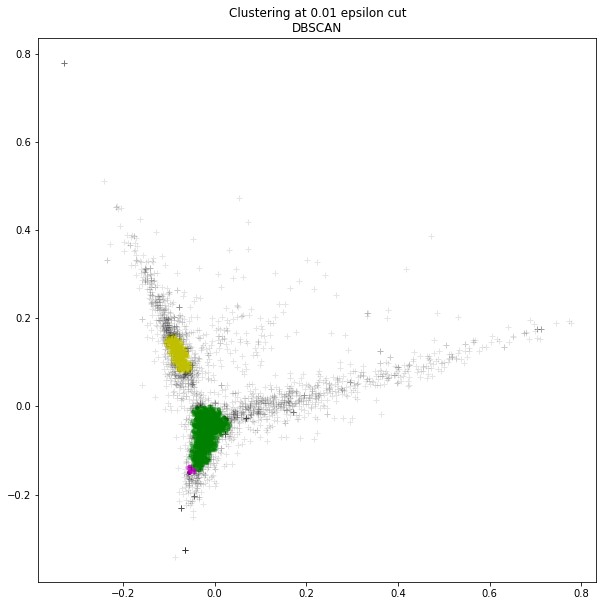

In [111]:
# DBSCAN at 2.
colors = ['g.', 'm.', 'y.', 'c.']
plt.subplots(figsize=(10,10))
for klass, color in zip(range(0, 4), colors):
    Xk = df[labels_200 == klass]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
plt.plot(df[labels_200 == -1, 0], df[labels_200 == -1, 1], 'k+', alpha=0.1)
plt.title('Clustering at 0.01 epsilon cut\nDBSCAN')
plt.savefig('output/DBSCAN@2.jpg')
plt.show()